<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_LDA_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

# the number of topics the Latent Dirichlet Allocation (LDA) model must extract from the set of documents
n_components = 24

In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
!pip install -U pymorphy3
import pymorphy3
import requests
import csv
import gzip
import shutil

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
alphabet_dash = alphabet | {'-'}# alphabet + dash

morph = pymorphy3.MorphAnalyzer(lang='ru')

from io import StringIO
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')
print(df.index.name)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.3 MB/s eta 0:00:00
None


In [3]:
def get_text_window(words, index, window_size=3):
    """Returns a context window of words around the given index."""
    start = max(0, index - window_size)
    end = min(len(words), index + window_size + 1)
    return ' '.join(words[start:end])

def contains_non_dash(s):
    """Check if a string consists not only dash characters."""
    return s.count('-') < len(s)

def process_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    processed_sentences = []

    for sentence in sentences:
        check_hash = False
        processed_parts = []
        words = word_tokenize(sentence)

        for i, w in enumerate(words):
          if len(w) == 1:
            continue
          if w == '#':
            check_hash = True
            continue
          if check_hash:
            check_hash = False
            continue

          # skip name and surname
          # w_tag = morph.parse(w.strip())[0].tag
          #if 'Surn' in w_tag or 'Name' in w_tag or 'Patr' in w_tag:
          #  context = get_text_window(words, i)
          #  print(f"Filtered name/surname: {w} | Context: {context}")  # Debug output for context
          #  continue

          if set(w.lower()).issubset(alphabet_dash) and contains_non_dash(w):
            res = morph.parse(w.lower())[0].normal_form
            if res and (res not in stop_words):
                  processed_parts.append(res)
          else:
            # has 4+ Cyrillic characters then will parse too (e.g. блж.Фаддея о.Алексия г.Петрозаводске)
            if sum(1 for char in w.lower() if char in alphabet) >= 4:
              if ('\\' not in w) and ('/' not in w): # skip words-hyperlinks
                #context = get_text_window(words, i)
                #print(f"Filtered not subset(alphabet): {w} | Context: {context}")
                res = morph.parse(w.lower())[0].normal_form
                if res not in stop_words:
                  processed_parts.append(res)

        if processed_parts:
            last_word = processed_parts[-1]
            if last_word[-1] not in ".!?":
                #processed_parts.append(".")  # Add period at the end of sentence
                processed_parts[-1] += "."    # Attach period directly to the last word

        processed_sentences.append(" ".join(processed_parts))

    return " ".join(processed_sentences).strip()

In [4]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'])  # .lower())

In [5]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # посчитать точность на тестовой сотне

unique_topics = sorted(train_docs['topic'].unique())  # sort topics by name
#print(f"Total topics: {len(unique_topics)}")
#for i, topic in enumerate(unique_topics, 1):  # print from 1
#    print(f"{i}. {topic}")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create TF-IDF matrix
#vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
# TODO: CountVectorizer лучше?
vectorizer = CountVectorizer(
#vectorizer = TfidfVectorizer(
    max_df=0.8,        # Игнорировать слишком частые слова (в >80% документов)
    min_df=2,          # Игнорировать слова, встречающиеся только один раз
    max_features=1000, # Умеренное количество признаков
#    stop_words=stop_words,  # уже убрали
)

# Transform text into TF-IDF matrix
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
doc_test_matrix = vectorizer.transform(test_docs['normalized'])

# Get feature names
words = vectorizer.get_feature_names_out()

# Generate topic labels
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    n_jobs=-1,
    max_iter=77,
    learning_method='batch',
    evaluate_every=10,
    verbose=1,
    random_state=42
)
lda.fit(doc_train_matrix)


# Save and load the model
joblib.dump(lda, 'model.pkl')
lda = joblib.load('model.pkl')

# Compute topic-word probabilities
topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)

# почему первый столбец - это названия группы в ВК (domain)?
topics.head()

iteration: 1 of max_iter: 77
iteration: 2 of max_iter: 77
iteration: 3 of max_iter: 77
iteration: 4 of max_iter: 77
iteration: 5 of max_iter: 77
iteration: 6 of max_iter: 77
iteration: 7 of max_iter: 77
iteration: 8 of max_iter: 77
iteration: 9 of max_iter: 77
iteration: 10 of max_iter: 77, perplexity: 797.2986
iteration: 11 of max_iter: 77
iteration: 12 of max_iter: 77
iteration: 13 of max_iter: 77
iteration: 14 of max_iter: 77
iteration: 15 of max_iter: 77
iteration: 16 of max_iter: 77
iteration: 17 of max_iter: 77
iteration: 18 of max_iter: 77
iteration: 19 of max_iter: 77
iteration: 20 of max_iter: 77, perplexity: 774.6637
iteration: 21 of max_iter: 77
iteration: 22 of max_iter: 77
iteration: 23 of max_iter: 77
iteration: 24 of max_iter: 77
iteration: 25 of max_iter: 77
iteration: 26 of max_iter: 77
iteration: 27 of max_iter: 77
iteration: 28 of max_iter: 77
iteration: 29 of max_iter: 77
iteration: 30 of max_iter: 77, perplexity: 759.8805
iteration: 31 of max_iter: 77
iteration: 32

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
100,0.000032,0.003458,0.000046,0.00017,0.000061,0.000039,0.000083,0.00015,0.000045,0.000066,...,0.001036,0.000068,0.000037,0.000049,0.000072,0.000039,0.000074,0.000131,0.002404,0.000119
100словокарелия,0.032038,0.000040,0.000046,0.00017,0.000061,0.000039,0.000083,0.00015,0.000045,0.000066,...,0.003971,0.000068,0.000037,0.000049,0.000072,0.000039,0.001863,0.000131,0.000023,0.000119
club147415188,0.000032,0.000040,0.000046,0.01242,0.000061,0.000039,0.000083,0.00015,0.001125,0.000066,...,0.000041,0.000068,0.000037,0.000049,0.001811,0.000039,0.000074,0.000131,0.000023,0.000119
club791498,0.000032,0.000040,0.000046,0.00017,0.000061,0.000039,0.000083,0.00015,0.000045,0.000066,...,0.000041,0.000068,0.000037,0.000049,0.000072,0.008423,0.000074,0.000131,0.000023,0.000119
cамый,0.012976,0.000040,0.000046,0.00017,0.000061,0.000039,0.000083,0.00015,0.000045,0.000066,...,0.000041,0.000068,0.000037,0.000049,0.000072,0.000039,0.000074,0.000131,0.000023,0.000119


In [7]:
# Extract top words per topic
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,пример,конкурс,карельский,карелов,вода,карелия,тверской,акция,карел,год,...,слово,карельский,который,человек,константин,музей,карельский,улица,карелия,фестиваль
1,слово,калевала,это,проект,карелия,год,карелия,детский,конкурс,работа,...,день,язык,год,район,семинар,карелия,язык,который,народный,озеро
2,свой,народ,карелия,культура,это,республика,стать,национальный,это,это,...,карельский,год,карелия,сутки,карелия,выставка,свой,новый,республика,наш
3,язык,свой,весь,танец,водопад,наш,первый,искусство,мастер,дом,...,карелия,национальный,семья,посёлок,наш,национальный,книга,наш,год,мир
4,100словокарелия,участие,наш,давать,который,общественный,республика,который,кухня,работать,...,это,вепсский,карельский,случай,традиция,национальныймузейкарелия,карелия,карелия,культура,вкарелииесть
5,конец,работа,николаевич,поддержка,река,новый,наш,карелия,весь,который,...,который,научный,история,коронавирус,море,республика,наречие,берест,хор,гость
6,стена,карелия,любовь,национальный,жемчуг,район,новый,ребёнок,соус,весь,...,вепсский,финский,день,ситуация,который,наш,вепс,пирог,коллектив,свой
7,опубликовать,творческий,который,политика,печь,развитие,карельский,творчество,который,хоровой,...,свой,республика,весь,республика,культура,история,финский,вопрос,песня,весь
8,неделя,культура,город,министерство,год,организация,работа,проект,карельский,всё,...,история,литература,всё,школа,россия,год,центр,человек,музыкальный,дом
9,месяц,участник,год,сюжет,образ,регион,также,школа,год,медицинский,...,финский,институт,республика,госпитализировать,заявка,который,который,участок,проект,программа


In [8]:
# Predict topic distribution for training data
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

# Prepare topic assignment per document
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)
#topic_pred = train_eval.idxmax(axis=1) # Get the topic with the highest probability for each document
#df = topic_pred.groupby(train_eval.index).value_counts(normalize=True).unstack(fill_value=0) # Group by true topic and count predictions


<ipython-input-8-b115e5e76e15>:6: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)


Text(0.5, 1.0, 'Training: Topic Distribution')

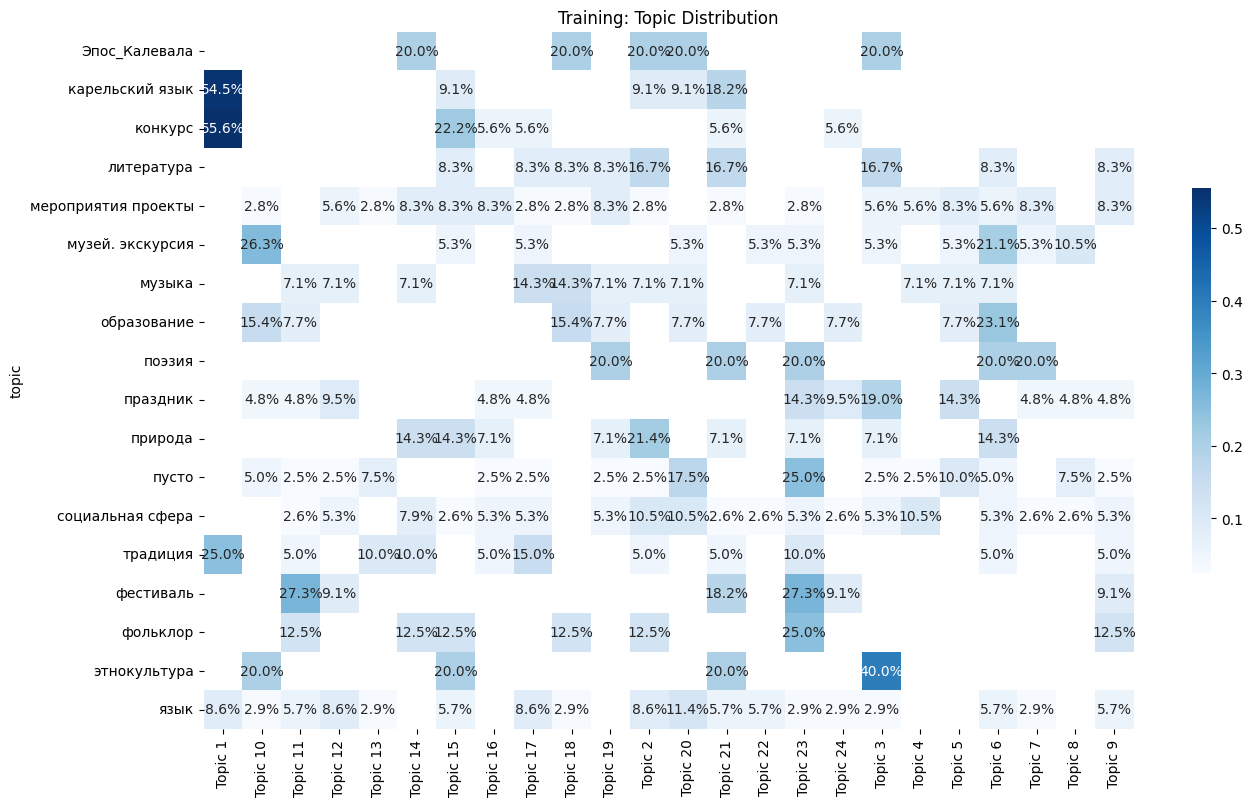

In [9]:
# Plot heatmap of topic distribution
plt.figure(figsize=(15, 10))
sns.heatmap(
    df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1),
    annot=True,
    fmt='.1%',
    cmap='Blues',
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Training: Topic Distribution')
#plt.title('Обучение: Тематики')

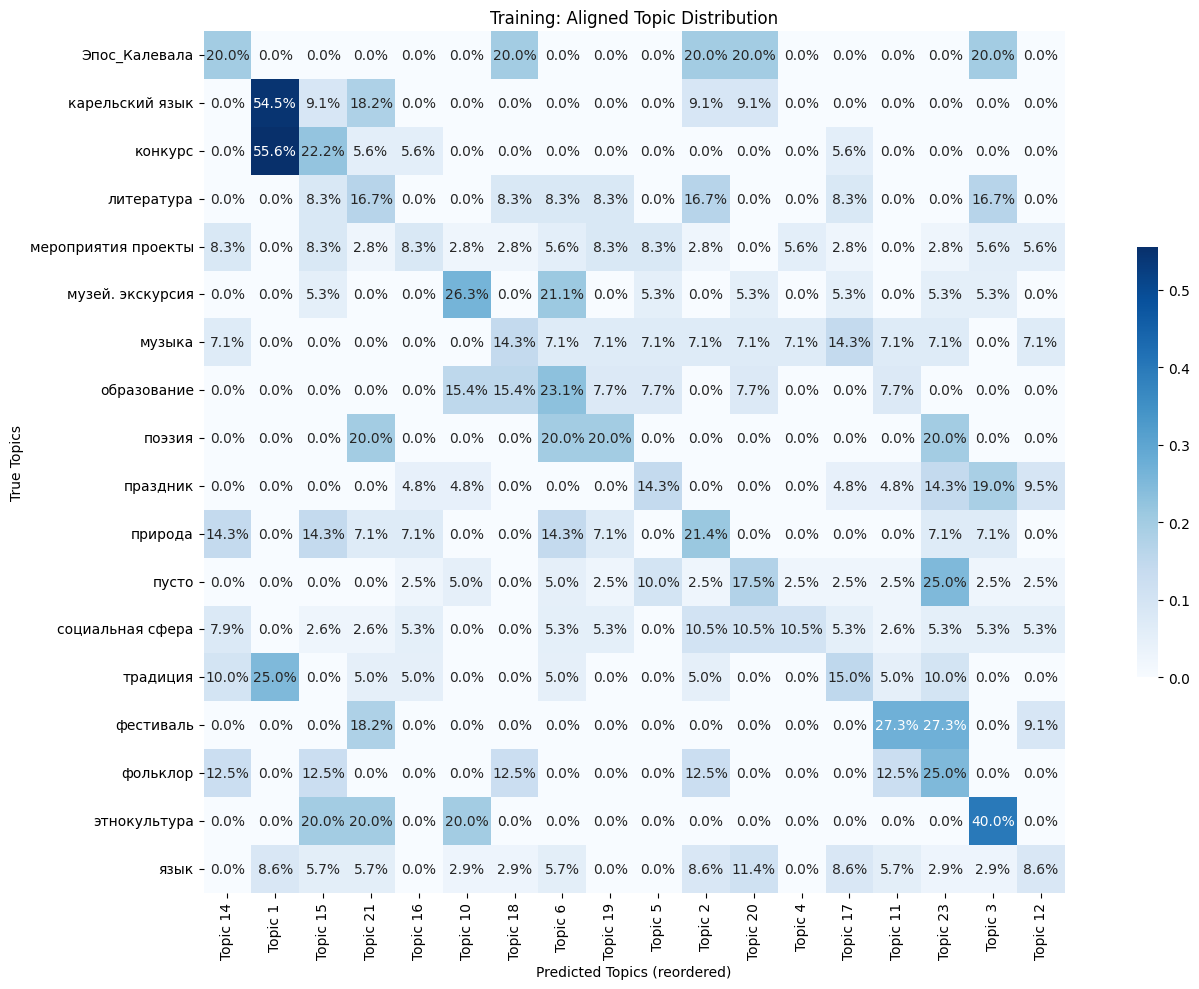

In [10]:
# Переупорядочиваем темы для максимального совпадения с истинными
confusion_matrix = df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1)

# Заполняем возможные NaN значения нулями и преобразуем к float
confusion_matrix = confusion_matrix.fillna(0).astype(float)

# Находим оптимальное сопоставление
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix.values)
    ordered_topics = confusion_matrix.columns[col_ind[np.argsort(row_ind)]]

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        confusion_matrix.loc[confusion_matrix.index, ordered_topics],
        annot=True,
        fmt='.1%',
        cmap='Blues',
        square=True,
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Training: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Ошибка при обработке матрицы: {e}")
    print("Матрица для проверки:")
    print(confusion_matrix)
    print("Типы данных в матрице:")
    print(confusion_matrix.dtypes)

Вторая часть марлезонского балета

Accuracy on the test set: 0.00%


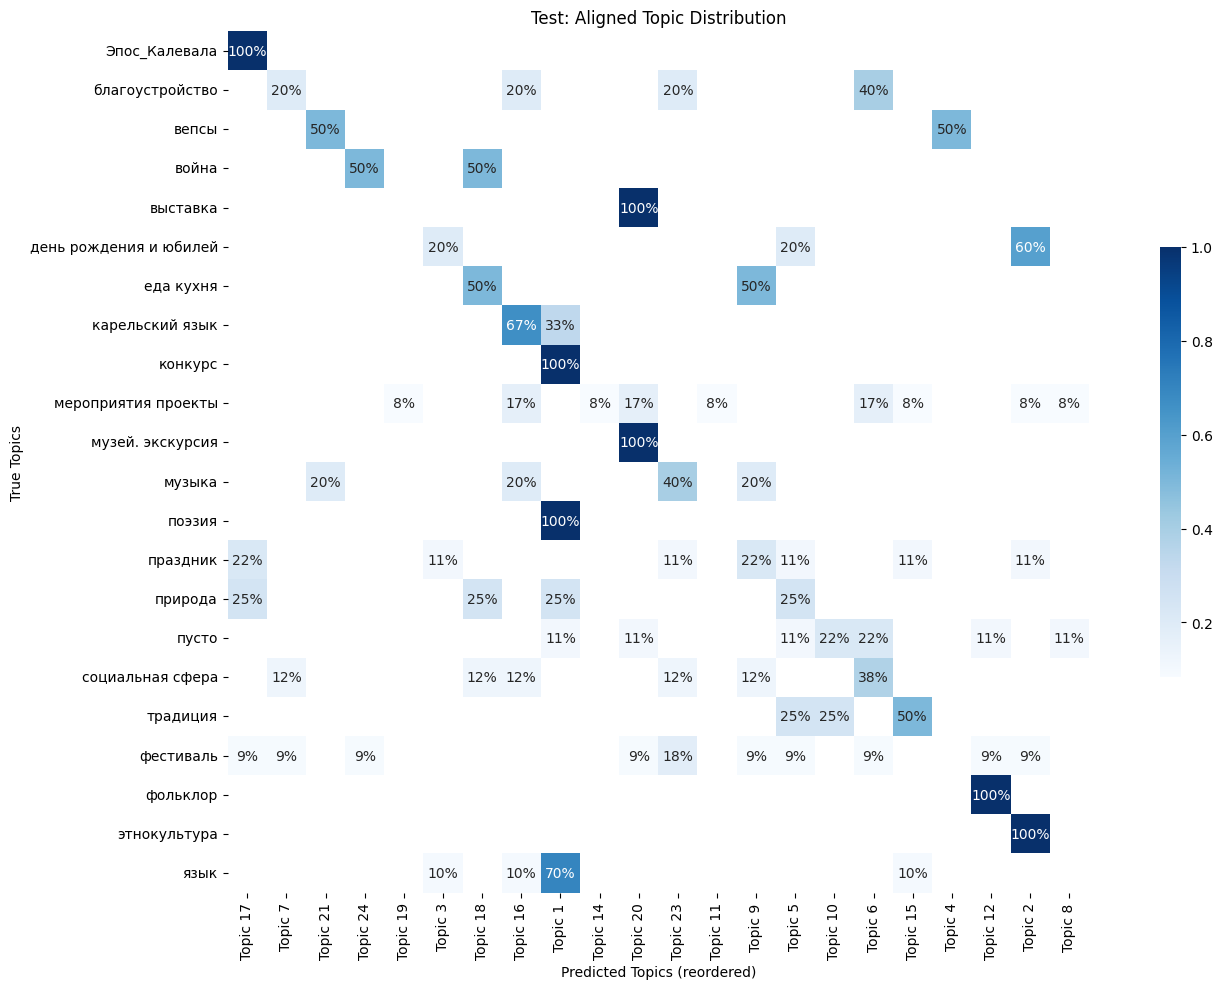

In [18]:
# Evaluation on the test set (second part of the file)

# Create DataFrames for predicted topic distributions (train and test)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)

test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

# Predict topic with the highest probability for each test document
# Save it to a DataFrame together with the original text
test_assignments = (
    test_eval.idxmax(axis=1)  # Predicted topic (with highest probability)
    .to_frame(name='predicted')
    .reset_index()            # Restore true topic as a column
)
test_assignments['text'] = test_docs.text.values

# Compute confusion matrix: how predicted topics match true topics
conf_matrix = test_assignments.groupby(['topic', 'predicted']).size().unstack(fill_value=0)
conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)  # Normalize by rows

# Reorder predicted topics to better match true ones
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-conf_matrix.values)
    ordered_predicted = conf_matrix.columns[col_ind[np.argsort(row_ind)]]

    # Create a mask for zero values (True means "mask this cell")
    mask = conf_matrix.loc[conf_matrix.index, ordered_predicted] == 0

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        conf_matrix.loc[conf_matrix.index, ordered_predicted],
        annot=True,
        fmt='.0%',         # Display as '0%' (no decimal)
        cmap='Blues',
        square=True,
        mask=mask,         # Mask cells with zero value
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Test: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Error while building heatmap: {e}")
    print(conf_matrix)

# Compute classification accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_assignments['topic'], test_assignments['predicted'])
print(f"Accuracy on the test set: {accuracy:.2%}")

# Save predictions for the topic 'война'
war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments.to_csv("war.csv", index=False)

# Save all predictions
test_assignments.to_csv("res.csv", index=False)